In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

import pandas

import numpy as np

import re

#from pushover import notify
from sksq96Utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

#%load_ext autoreload
#%autoreload 2

In [2]:
# Device configuration
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


In [3]:
bs = 32



In [4]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        esp = esp.to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
    


In [5]:
image_channels = 3
model = VAE(image_channels=image_channels).to(device)
model.load_state_dict(torch.load('vae.torch', map_location=device))
model=model.to(device)

In [6]:
from torch.utils.data import DataLoader, Dataset
import glob




class CustomDatasetFromFile(Dataset):
    def __init__(self, folder_path, data_len, image_list):
        """
        A dataset example where the class is embedded in the file names
        This data example also does not use any torch transforms

        Args:
            folder_path (string): path to image folder
        """
        # Get image list
        self.image_list = image_list
        ## Calculate len
        self.data_len = data_len
        self.num_samples = data_len
        
        
        
        


    def __getitem__(self, index):
        from PIL import Image
        # Get image name from the pandas df
        single_image_path = self.image_list[index]

        
        ImageNameDataList = single_image_path[39:-4]
        imageGroupNumber = ImageNameDataList.split("_")[0]
        imageFrameNumber = ImageNameDataList.split("_")[1]
        prevFrameNumber = max(1,int(imageFrameNumber)-1)
        
        previous_image_path2 = glob.glob(f'D:/Kris\'s Workbench/FYP/TrainingData/0/'+str(imageGroupNumber)+'_'+str(prevFrameNumber)+'_'+'*')[0]
            
        # Open image
        im_as_im = Image.open(single_image_path)
        previousim_as_im = Image.open(previous_image_path2)
        
        preprocess=transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(), 
            ])
        
        im_preprocessed = preprocess(im_as_im)
        previousim_preprocessed = preprocess(previousim_as_im)
        return (im_preprocessed,previousim_preprocessed,ImageNameDataList)

    def __len__(self):
        return len(self.image_list)

In [7]:
folder_path=f'D:/Kris\'s Workbench/FYP/TrainingData/0/'
image_list = glob.glob(folder_path+'*')
data_len = len(image_list)

dataset = CustomDatasetFromFile(folder_path=f'D:/Kris\'s Workbench/FYP/TrainingData/0/',data_len=data_len, image_list=image_list)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)


torch.Size([1, 3, 64, 64])


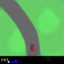

In [8]:
# Fixed input for debugging
CurrentImage, PreviousImage, _ = next(iter(dataloader))
print(CurrentImage.shape)
curr, _, _ = model.encode(CurrentImage.to(device))
prev, _, _ = model.encode(PreviousImage.to(device))
#concatenatedTensor = torch.cat((prev, curr), 0)

save_image(model.decode(curr)[0], 'imagea.png')
save_image(model.decode(prev)[0], 'imageb.png')

#def decodeConcatenatedTensor(Tensor):
#    a, b = concatenatedTensor.split(32, dim=0)
#    aDecoded = model.decode(a)
#    bDecoded = model.decode(b)
#    save_image(aDecoded[0], 'imagea.png')
#    save_image(aDecoded[0], 'imageb.png')
    


#decodeConcatenatedTensor(concatenatedTensor)
from IPython.display import Image
Image(filename='imagea.png')

# print(a.shape)
# print(b.shape)
# recon_images = model.decode(b)
# save_image(recon_images[0], 'test_image.png')
# from IPython.display import Image
# Image(filename='test_image.png')


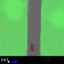

In [9]:

Image(filename='imageb.png')

In [10]:
#Neural Network Parameters
num_epochs = 30
batch_size = bs
learning_rate = 0.001

input_size = 64 #Dimensions of the input "concatenatedTensor"
hidden_size = [32,16,8]
num_classes = 3 #Three state outputs. Acceleration. Braking. Turning Angle

#rint(concatenatedTensor.shape)

#Define neural network for this part
class StateDetectionNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(StateDetectionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0]) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1]) 
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2]) 
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size[2], num_classes)  
    
    def forward(self, x):
        out = self.fc1(x.reshape(-1,input_size))
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

model2 = StateDetectionNet(input_size, hidden_size, num_classes).to(device)

#Define loss and optimizer
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)  

In [11]:

def getResultsFromStateVariables(statevariables):
    
    expectedResults = np.asarray(statevariables)
    expectedResults2 = np.char.split(expectedResults,"_")
    expectedResults3 = np.asarray(expectedResults2)
    expectedResults4 = np.stack(expectedResults3, axis=0)
    expectedResults5 = expectedResults4[0:,2:5]
    expectedResults6 = expectedResults5.astype(np.float)
    
    mean_col1 = -0.026595786253976014
    mean_col2 = 0.21783560955090628
    mean_col3 = 0.007642476004356518
    sd_col1 = 0.10711904839787884
    sd_col2 = 0.09744389996469334
    sd_col3 = 0.043793150114235936
    
    col1 = (expectedResults6[:,0]-mean_col1)/sd_col1
    col2 = (expectedResults6[:,1]-mean_col2)/sd_col2
    col3 = (expectedResults6[:,2]-mean_col3)/sd_col3
    expectedResults7 = np.column_stack((col1,col2,col3))
    
    expectedResults8 = torch.FloatTensor(expectedResults7).to(device)
    
    return expectedResults8

In [14]:
#Training
for epoch in range(num_epochs):
    running_loss = 0
    for idx, (CurrentImage, PreviousImage, statevariables) in enumerate(dataloader):
        expectedResults = getResultsFromStateVariables(statevariables)       
        
        CurrentImage = CurrentImage.to(device)
        PreviousImage = PreviousImage.to(device)
        curr, _, _ = model.encode(CurrentImage.to(device))
        prev, _, _ = model.encode(PreviousImage.to(device))
        concatenatedTensor = torch.cat([prev, curr], dim=1)
        #print(expectedResults)
        
        out = model2(concatenatedTensor)
        loss = nn.MSELoss()
        loss = loss(out, expectedResults)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
        
        #to_print = "Loss: {:.9f}".format(loss.data.item()/bs)
        #print(idx)
        #print(model2.state_dict())
        #print(expectedResults8)
        #print(statevariables)
        #
    to_print = "Epoch[{}/{}] Loss: {:.9f}".format(epoch+1,num_epochs, running_loss)#loss.data.item()/bs
    print(to_print)
    torch.save(model2.state_dict(), 'CurrentConditions.torch')
    #print(epoch)
        
torch.save(model2.state_dict(), 'CurrentConditions.torch')

Epoch[1/30] Loss: 748.759565357
Epoch[2/30] Loss: 729.585540242
Epoch[3/30] Loss: 704.056547445
Epoch[4/30] Loss: 703.061175407
Epoch[5/30] Loss: 695.029658990
Epoch[6/30] Loss: 677.158094002
Epoch[7/30] Loss: 659.134466995
Epoch[8/30] Loss: 657.487108619
Epoch[9/30] Loss: 724.753099207
Epoch[10/30] Loss: 681.450049417
Epoch[11/30] Loss: 641.133793038
Epoch[12/30] Loss: 619.139516890
Epoch[13/30] Loss: 622.958074915
Epoch[14/30] Loss: 613.505535516
Epoch[15/30] Loss: 636.061652295
Epoch[16/30] Loss: 620.829412074
Epoch[17/30] Loss: 619.568808940
Epoch[18/30] Loss: 609.630934156
Epoch[19/30] Loss: 614.998765244
Epoch[20/30] Loss: 592.249316667
Epoch[21/30] Loss: 590.014225107
Epoch[22/30] Loss: 647.765436259
Epoch[23/30] Loss: 559.476275864
Epoch[24/30] Loss: 580.418957630
Epoch[25/30] Loss: 599.963191128
Epoch[26/30] Loss: 592.826866930
Epoch[27/30] Loss: 600.179440994
Epoch[28/30] Loss: 570.422828909
Epoch[29/30] Loss: 570.399484426
Epoch[30/30] Loss: 580.956094670


In [13]:
#bs = 128
model2.load_state_dict(torch.load('CurrentConditions.torch', map_location=device))

<All keys matched successfully>

In [13]:
CurrentImage, PreviousImage, statevariables = next(iter(dataloader))
curr, _, _ = model.encode(CurrentImage.to(device))
prev, _, _ = model.encode(PreviousImage.to(device))
concatenatedTensor = torch.cat([prev, curr], dim=0)
out = model2(concatenatedTensor)
#out = out.cpu().detach().numpy() 
#mean_col1 = -0.026595786253976014
#mean_col2 = 0.21783560955090628
#mean_col3 = 0.007642476004356518
#sd_col1 = 0.10711904839787884
#sd_col2 = 0.09744389996469334
#sd_col3 = 0.043793150114235936
        
#col1 = (out[:,0]-mean_col1)/sd_col1
#col2 = (out[:,1]-mean_col2)/sd_col2
#col3 = (out[:,2]-mean_col3)/sd_col3
#out = np.column_stack((col1,col2,col3))
#out = torch.FloatTensor(out).to(device)
print(out)


expectedResults = getResultsFromStateVariables(statevariables)
print(expectedResults)

print(out-expectedResults)

#print(expectedResults.tolist()[0]*float(out.tolist()[0][0]))

tensor([[ 0.2648,  0.3936, -0.1765]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.2313,  0.4547, -0.1745]], device='cuda:0')
tensor([[ 0.0335, -0.0611, -0.0020]], device='cuda:0', grad_fn=<SubBackward0>)


In [54]:
expectedResults = list(statevariables)
expectedResults= np.asarray(statevariables)#statevariables[1].split("_")
expectedResults = np.char.split(expectedResults,"_")
expectedResults= np.asarray(expectedResults)
expectedResults=np.stack(expectedResults, axis=0)
expectedResults = expectedResults[0:,2:5]
expectedResults = expectedResults.astype(np.float)
expectedResults = torch.from_numpy(expectedResults)
#expectedResults = list(np.float_(expectedResults))[2:5]
#expectedResults = torch.FloatTensor(expectedResults).to(device)
print(expectedResults)

tensor([[-0.0010,  0.2621,  0.0000],
        [ 0.1692,  0.0000,  0.2621],
        [ 0.0000,  0.2621,  0.0000],
        [ 0.0000,  0.2621,  0.0000],
        [ 0.0000,  0.0344,  0.0000],
        [ 0.0000,  0.2621,  0.0000],
        [ 0.0000,  0.2621,  0.0000],
        [-0.2746,  0.2621,  0.0000],
        [ 0.0000,  0.2621,  0.0000],
        [-0.0805,  0.0000,  0.2621],
        [-0.2746,  0.0000,  0.2621],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0034,  0.2621,  0.0000],
        [ 0.0000,  0.2621,  0.0000],
        [-0.2746,  0.0000,  0.0000],
        [ 0.0000,  0.2621,  0.0000],
        [-0.2746,  0.2621,  0.0000],
        [ 0.0000,  0.2621,  0.0000],
        [-0.2746,  0.2621,  0.0000],
        [ 0.0000,  0.0000,  0.2621],
        [-0.2746,  0.0000,  0.0123],
        [ 0.0000,  0.2621,  0.0000],
        [-0.2746,  0.2621,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.2621,  0.0000],
        [ 0.0000,  0.2621,  0.0000],
        [ 0.0143,  0.2621,  0.0000],
 

In [29]:
folder_path=f'D:/Kris\'s Workbench/FYP/TrainingData/0/'
image_list = glob.glob(folder_path+'*')
data_len = len(image_list)
num_samples = data_len

finalList = list()
for index in range(num_samples):
        single_image_path = image_list[index]
        ImageNameDataList = single_image_path[39:-4]
        finalList.append(ImageNameDataList)
        


expectedResults= np.asarray(finalList)#statevariables[1].split("_")
expectedResults = np.char.split(expectedResults,"_")
expectedResults= np.asarray(expectedResults)
expectedResults=np.stack(expectedResults, axis=0)
expectedResults = expectedResults[0:,2:5]
expectedResults = expectedResults.astype(np.float)

col1 = expectedResults[:,0]
col2 = expectedResults[:,1]
col3 = expectedResults[:,2]
print(np.std(col3))

mean_col1 = -0.026595786253976014
mean_col2 = 0.21783560955090628
mean_col3 = 0.007642476004356518
sd_col1 = 0.10711904839787884
sd_col2 = 0.09744389996469334
sd_col3 = 0.043793150114235936

0.043793150114235936
